In [216]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.spatial.distance import pdist, squareform

In [217]:
def display_scaled(pic, scale=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((int(w * scale), int(h * scale)), Image.LANCZOS))

In [218]:
def show_gray_hist(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.plot(hist)
    plt.xlim([0, 255])
    plt.show()

In [219]:
def order_ccw(pts):
    c = pts.mean(axis=0)
    angles = np.arctan2(pts[:, 1] - c[1], pts[:, 0] - c[0])
    pts = pts[np.argsort(angles)]
    tl_idx = np.argmin(pts.sum(axis=1))
    return np.roll(pts, -tl_idx, axis=0).astype(np.float32)

In [220]:
def calculate_side_lengths(corners):
    corners = np.squeeze(corners)
    side_lengths = []
    diagonal_lengths = []

    for i in range(4):
        point1 = corners[i]
        point2 = corners[(i + 1) % 4]
        length = np.linalg.norm(point2 - point1)
        side_lengths.append(length)
    shortest = min(side_lengths)
    longest = max(side_lengths)
    side_aspect = longest / shortest

    diagonal1 = np.linalg.norm(corners[0] - corners[2])
    diagonal_lengths.append(diagonal1)
    diagonal2 = np.linalg.norm(corners[1] - corners[3])
    diagonal_lengths.append(diagonal2)
    shortest = min(diagonal_lengths)
    longest = max(diagonal_lengths)
    diag_aspect = longest / shortest

    return side_lengths, side_aspect, diagonal_lengths, diag_aspect

In [221]:
def process_reference_images(ref_dir, contrastThreshold=0.01, edgeThreshold=15, nOctaveLayers=11, sigma=1.75, verbose=0):
    
    sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)
    ref_data = []

    for file in Path(ref_dir).rglob("*"):
        
        if not file.is_file():
            continue
        
        card_to_search_color = cv2.imread(str(file))

        if card_to_search_color is None:
            continue
        if verbose > 2: display_scaled(card_to_search_color, 0.5)

        card_to_search_gray = cv2.cvtColor(card_to_search_color, cv2.COLOR_BGR2GRAY)
        if verbose > 2: display_scaled(card_to_search_gray, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_gray)

        _, card_to_search_thresh = cv2.threshold(card_to_search_gray, 150, 255, cv2.THRESH_BINARY)
        card_to_search_masked = cv2.bitwise_and(card_to_search_gray, card_to_search_gray, mask=card_to_search_thresh)
        if verbose > 2: display_scaled(card_to_search_masked, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_masked)

        ref_kp, ref_des = sift.detectAndCompute(card_to_search_masked, None)
        if verbose > 0: print(f'{str(file)} -> {len(ref_kp)} key-points found')

        if verbose > 1: 
            ref_kp_img = cv2.drawKeypoints(card_to_search_color, ref_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            display_scaled(ref_kp_img, 0.5)

        card_face = file.name.split(".")[0]
        ref_data.append((card_face, ref_kp, ref_des, card_to_search_color))
    
    return ref_data

In [222]:
def process_image(img_name, contrastThreshold=0.01, edgeThreshold=15, nOctaveLayers=11, sigma=1.75, verbose=0):
    
    sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)

    img_to_process_color = cv2.imread(img_name)
    if verbose > 2: display_scaled(img_to_process_color, 0.2)

    img_to_process_gray = cv2.cvtColor(img_to_process_color, cv2.COLOR_BGR2GRAY)
    if verbose > 2: display_scaled(img_to_process_gray, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_gray)

    _, img_to_process_thresh = cv2.threshold(img_to_process_gray, 150, 255, cv2.THRESH_BINARY)
    img_to_process_masked = cv2.bitwise_and(img_to_process_gray, img_to_process_gray, mask=img_to_process_thresh)
    if verbose > 2: display_scaled(img_to_process_masked, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_masked)
    
    kp, des = sift.detectAndCompute(img_to_process_masked, None)

    if verbose > 0: print(f'{len(kp)} key-points found in {img_name}')

    if verbose > 1: 
        kp_img = cv2.drawKeypoints(img_to_process_color, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        display_scaled(kp_img, 0.5)

    #edges = cv2.Canny(img_to_process_masked, 100, 200)
    #contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return kp, des, img_to_process_color, img_to_process_masked#, contours

In [223]:
def get_matches(des_reference, des_image, distance_ratio=0.75, verbose=0):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = matcher.knnMatch(des_reference, des_image, k=2)
    good_matches = [m for m, n in matches if m.distance < distance_ratio * n.distance]
    
    if verbose > 0: print(f"{len(good_matches)} good matches out of {len(matches)} total matches")
    
    return matches, good_matches

In [224]:
def findHomography(src_pts, dst_pts, max_iters=10000):
    M1, mask1 = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=max_iters, confidence=0.995)
    M1 = np.vstack([M1, [0, 0, 1]])
    name = "estimateAffine2D (RANSAC)"
    ret_M = M1
    ret_mask = mask1
    
    M2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0, maxIters=max_iters, confidence=0.995)
    if np.sum(mask2) > np.sum(ret_mask):
        name = "findHomography (RANSAC)"
        ret_M = M2
        ret_mask = mask2

    M3, mask3 = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, 2.0, maxIters=max_iters, confidence=0.995)
    if np.sum(mask3) > np.sum(ret_mask):
        name = "findHomography (USAC_ACCURATE)"
        ret_M = M3
        ret_mask = mask3
    
    return name, ret_M, ret_mask

In [225]:
def find_cards(reference_card_data, kp, des, distance_ratio = 0.75, max_iters=10000, verbose=0):

    found = []

    for ref_name, ref_kp, ref_des, ref_img_color in reference_card_data:
        if verbose > 0: print(f"processing {ref_name}...")

        matches, good_matches = get_matches(ref_des, des, distance_ratio=distance_ratio, verbose=verbose)
        
        if len(good_matches) >= 8:
            if verbose > 0: print(f'{len(good_matches)} out of {len(matches)} is {len(good_matches) / len(matches)} rate')

            src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            if verbose > 0: print(f"trying to match src_pts.shape={src_pts.shape} dst_pts.shape={dst_pts.shape}")

            h, w = ref_img_color.shape[:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
            name, M, mask = findHomography(src_pts, dst_pts, max_iters=max_iters)
            if verbose > 0: print(f"{name} found {np.sum(mask)} inliers out of {len(good_matches)} good matches")
            dst = cv2.perspectiveTransform(pts, M)
            found.append((ref_name, name, dst, np.sum(mask), len(good_matches), len(matches)))
    
    return found

In [226]:
def get_centroid_mean_distance(quads):
    widths = []
    heights = []

    for quad in quads:
        quad = order_ccw(quad.reshape(4, 2))

        top_width = np.linalg.norm(quad[1] - quad[0])
        bottom_width = np.linalg.norm(quad[2] - quad[3])
        left_height = np.linalg.norm(quad[3] - quad[0])
        right_height = np.linalg.norm(quad[2] - quad[1])

        avg_width = (top_width + bottom_width) / 2
        avg_height = (left_height + right_height) / 2

        widths.append(avg_width)
        heights.append(avg_height)

    return np.mean(widths), np.mean(heights)

In [227]:
def group_by_centroid_proximity(quads, threshold=25):
    centroids = np.array([quad.reshape(4, 2).mean(axis=0) for quad in quads])
    distances = squareform(pdist(centroids))
   
    n = len(quads)
    group_labels = -np.ones(n, dtype=int)
    group_id = 0
    
    for i in range(n):
        if group_labels[i] != -1:
            continue
        group_labels[i] = group_id
        for j in range(i + 1, n):
            if distances[i, j] < threshold:
                group_labels[j] = group_id
        group_id += 1
        
    return group_labels

In [228]:
def refine_found_data(found_data, img_to_process_color, threshold=25, verbose=0):
    refined = {}
    refined_final = {}
    ret = []

    for ref_name, hname, dst, l_mask, l_good_matches, l_matches in found_data:
        h, w = img_to_process_color.shape[:2]
        cntrarea = cv2.contourArea(dst)

        if cv2.isContourConvex(dst) == False:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: not convex")
            continue

        if any(dst[dst<0]) or any(dst[:, :, 0] > w) or any(dst[:, :, 1] > h):
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: dst={dst} out of bounds")
            continue

        if cntrarea < h*w*0.001 or cntrarea > h*w*0.85:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: area={cntrarea} (full is {h*w})")
            continue

        if l_mask < 6:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: {l_mask} {l_good_matches} {l_matches}")
            continue

        side_lengths, side_aspect, diagonal_lengths, diag_aspect = calculate_side_lengths(dst)
        if side_aspect > 2.5:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: side aspect={side_aspect} too long")
            continue

        if diag_aspect > 1.333:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: diag aspect={diag_aspect} too long")
            continue
        
        if verbose > 0: print(f"{ref_name} with {hname} found {l_mask} inliers out of {l_good_matches} good matches out of {l_matches} total matches -> area={cv2.contourArea(dst)} (full is {h*w})")
        
        if ref_name not in refined.keys():
            refined[ref_name] = {'min_dst': dst, 'score': l_mask}
        else:
            if l_mask > refined[ref_name]['score']:
                refined[ref_name]['score'] = l_mask
            if cntrarea < cv2.contourArea(refined[ref_name]['min_dst']):
                refined[ref_name]['min_dst'] = dst

    all_dst = []
    for ref in refined:
        all_dst.append(refined[ref]['min_dst'])

    mean_width, mean_height = get_centroid_mean_distance(all_dst)
    dynamic_distance = np.min([mean_width, mean_height])
    print(dynamic_distance)
    groups  = group_by_centroid_proximity(all_dst, threshold=dynamic_distance)
    if verbose > 0: print(f"created {np.max(groups)+1} groups from {len(all_dst)} distances")

    for ref, grp in zip(refined.keys(), groups):
        refined[ref]['group'] = grp

    for ref in refined:
        grp = refined[ref]['group']
        if verbose > 0: print(f'checking {ref}')
        if grp not in refined_final.keys():
            if verbose > 0: print(f'adding {grp} group with {ref}')
            refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}
        else:
            if verbose > 0: print(f"{ref} group is already exists with {refined_final[grp]['score']} {refined[ref]['score']} is to match")
            if refined[ref]['score'] > refined_final[grp]['score']:
                if verbose > 0: print(f'modifying {grp} group -> new face {ref}')
                refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}

    for key, value in refined_final.items():
        ret.append((value['min_dst'].squeeze(axis=1), value['face'], value['score']))

    return ret

In [229]:
REFERENCES_DIR = "refs3"
reference_card_data = process_reference_images(REFERENCES_DIR, verbose=0)

In [230]:
#TEST_IMG_NAME = "pics2/test_image - 19.jpeg"
TEST_IMG_NAME = "pics2/20.jpeg"
kp, des, img_to_process_color, img_to_process_masked = process_image(TEST_IMG_NAME, verbose=0)

In [231]:
DISTANCE_RATIO = 0.9
MAX_ITERS = 25000
found_data = find_cards(reference_card_data, kp, des, distance_ratio=DISTANCE_RATIO, max_iters=MAX_ITERS, verbose=0)
#matches_img = cv2.drawMatches(ref_img_color, ref_kp, img_to_process_color, kp, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

In [232]:
THRESHOLD = 500
refined_found_data = refine_found_data(found_data, img_to_process_color, threshold=THRESHOLD, verbose=0)

786.8508


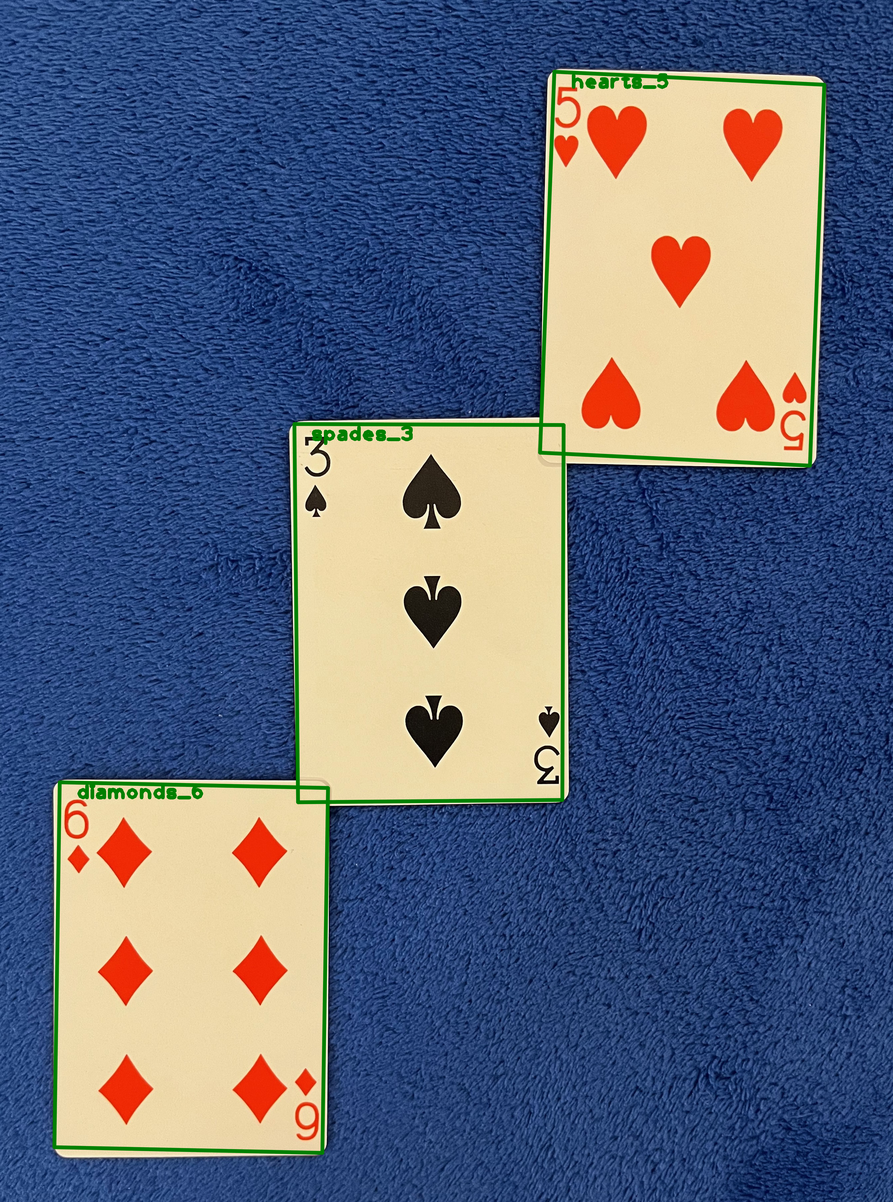

In [233]:
result_img_annotated = img_to_process_color.copy()

for quad, face, _ in refined_found_data:
    result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (0, 128, 0), 10, cv2.LINE_AA)
    cv2.putText(result_img_annotated, face, tuple(np.int32(order_ccw(quad)[0])+50), cv2.FONT_HERSHEY_PLAIN, 4, (0, 128, 0), 10)

display_scaled(result_img_annotated, 0.333)